$nCycles$ - number of simulation cycles

$nBuyers$  - number of the buyers

$nSellers$ - number of the sellers

$seed$ - the seed of the random numbers

$d_0$ - the lower bound for random uniform numbers, both for the buyers and the sellers in the warming up phase; in the running phase, the lower bound is $0$

$d_1$ - the upper bound for random uniform numbers for the buyers

$d_2$ - the upper bound for random uniform numbers for the sellers

initial buyer $i$ reservation price, different for each buyer: $p_{b,i}=\frac{1} {1 + u_i}$ with $u_i\sim\mathcal{U}(d_0,d_1)$

initial seller j reservation price, different for each seller: $p_{s,j}=1 + u_j$ with $u_j\sim\mathcal{U}(d_0,d_2)$

the running prices are changing following the correction coefficients:

$c_b=\frac{1} {1 + u_b}$ or $c_b=1 + u_b$ with $u_b\sim\mathcal{U}(0,d_1)$

$c_s=\frac{1} {1 + u_s}$ or $c_s=1 + u_s$ with $u_s\sim\mathcal{U}(0,d_2)$

$buyersSellersRatio$ - the ratio $\frac{nBuyers}{nSellers}$

$sellersBuyersRatio$ - the ratio $\frac{nSellers}{nBuyers}$

$usingRatios$ - a logic variable activating limitations to $d_1$ or $d_2$

$squeezeRate$ - always $< 1$, as further compression of $d_1$ or $d_2$

$usingSqueezeRate$ - a logic variable to further squeeze $d_1$ or $d_2$


In [1]:
%pylab inline
import statistics as s
import numpy as np
import pylab as plt
from ipywidgets import Output
from IPython.display import clear_output
from IPython.display import display
import time
import math

Populating the interactive namespace from numpy and matplotlib


In [4]:
# warming up

# execute before both: 
#                     - the hayekian perspective or
#                     - the unstructured case
def warmingUp():
    global nCycles, nBuyers, nSellers,\
        buyersSellersRatio, sellersBuyersRatio,\
        usingRatios, usingSqueezeRate, squeezeRate,\
        d0, d1, d2, buyerPriceList, sellerPriceList

    nCycles=10000
    nBuyers= 100
    nSellers=100

    buyersSellersRatio=nBuyers/nSellers
    sellersBuyersRatio=nSellers/nBuyers
    usingRatios=True
    squeezeRate=0.3 # always < 1 
    usingSqueezeRate=False

    seed=111
    np.random.seed(seed)

    d0=0.1
    d1=0.2
    d2=0.2


    buyerPriceList=[]
    sellerPriceList=[]

    for i in range(nBuyers):
        buyerPriceList.append(1/(1+np.random.uniform(d0,d1)))
    for j in range(nSellers):
        sellerPriceList.append(1+np.random.uniform(d0,d2))
    
    plt.figure(0)
    plt.plot(sorted(buyerPriceList,reverse=True),"r");
    plt.plot(sorted(sellerPriceList),"b");
    xlabel("the agents");
    ylabel("agents' reservation prices");

Output()

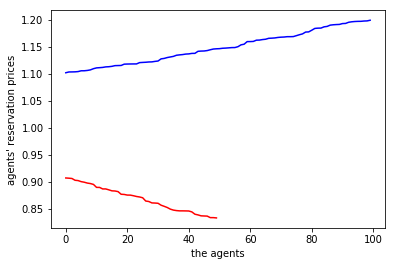

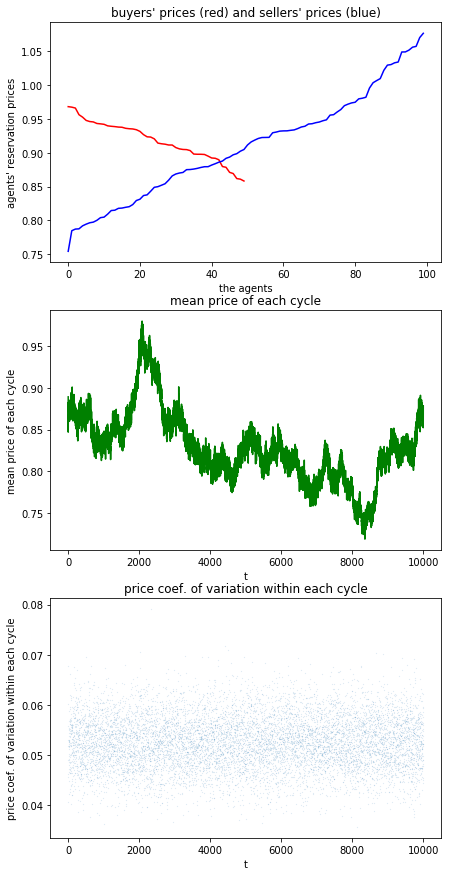

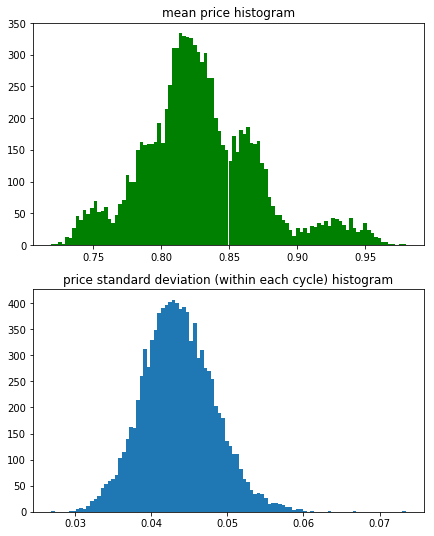

In [5]:
# simplified hayekian perspective

warmingUp()

out = Output()
display(out)

meanPrice_ts=[]
meanPriceStDev_ts=[]
meanPriceVar_ts=[]

if usingRatios and not usingSqueezeRate:
    if buyersSellersRatio>1: d2*=sellersBuyersRatio
    if sellersBuyersRatio>1: d1*=buyersSellersRatio
        
if usingRatios and usingSqueezeRate:
    if buyersSellersRatio>1: d2*=sellersBuyersRatio*squeezeRate
    if sellersBuyersRatio>1: d1*=buyersSellersRatio*squeezeRate
    

for t in range(1,nCycles+1):    
    dealPrices=[]
    agNum=max(nBuyers,nSellers)

    for n in range(agNum):

        i = np.random.randint(0,nBuyers)
        j = np.random.randint(0,nSellers)
        
        if buyerPriceList[i]>=sellerPriceList[j]:
            dealPrices.append(sellerPriceList[j])
            buyerPriceList[i] *=1/(1+np.random.uniform(0,d1))
            sellerPriceList[j]*=1+np.random.uniform(0,d2)
        else:
            buyerPriceList[i] *=1+np.random.uniform(0,d1)
            sellerPriceList[j]*=1/(1+np.random.uniform(0,d2))
           
    if len(dealPrices) > 2:
        meanPrice_ts.append(s.mean(dealPrices))
        meanPriceVar_ts.append(s.variance(dealPrices))
        meanPriceStDev_ts.append(s.stdev(dealPrices))
    else:
        meanPrice_ts.append(np.nan)
        meanPriceStDev_ts.append(np.nan)

    if t % 1000==0:
        with out:
            clear_output()
        with out:
            print('time', t, 'and n. of exchanges in the last cycle', \
              len(dealPrices))
            print(\
        'mean and var of exchange prices in the last cycle: %1.3e, %1.3e' %\
              (meanPrice_ts[-1],meanPriceVar_ts[-1]))

        plt.figure(1,figsize=(7,15),clear=True)

        plt.subplot(311)
        plt.plot(sorted(buyerPriceList,reverse=True),"r")
        plt.plot(sorted(sellerPriceList),"b")
        plt.title(\
            "buyers' prices (red) and sellers' prices (blue)")
        xlabel("the agents")
        ylabel("agents' reservation prices")

        plt.subplot(312)
        plt.title("mean price of each cycle")
        xlabel("t")
        ylabel("mean price of each cycle")
        plt.plot(meanPrice_ts,"g")
        
        plt.subplot(313)
        plt.title("price coef. of variation within each cycle")
        coefOfVariation=[]
        for m in range(len(meanPriceStDev_ts)):
            coefOfVariation.append(meanPriceStDev_ts[m]/
                                   meanPrice_ts[m])
        plt.plot(coefOfVariation,".",markersize=0.1)
        xlabel("t")
        ylabel("price coef. of variation within each cycle")
        #time.sleep(0.1)

# hist crashes with NaN
meanPrice_ts_hist=[]
for k in range(len(meanPrice_ts)): 
    if not math.isnan(meanPrice_ts[k]):
        meanPrice_ts_hist.append(meanPrice_ts[k])
meanPriceStDev_ts_hist=[]
for k in range(len(meanPriceStDev_ts)): 
    if not math.isnan(meanPriceStDev_ts[k]):
        meanPriceStDev_ts_hist.append(meanPriceStDev_ts[k])
plt.figure(2,figsize=(7,9))
plt.subplot(211)
if meanPrice_ts_hist != []:
    plt.title("mean price histogram")
    plt.hist(meanPrice_ts_hist,100,color="g");
plt.subplot(212)
if meanPriceStDev_ts_hist != []:
    plt.title("price standard deviation (within each cycle) histogram")
    plt.hist(meanPriceStDev_ts_hist,100);

In [ ]:
# unstructured case

warmingUp()

out = Output()
display(out)

meanPrice_ts=[]
meanPriceStDev_ts=[]
meanPriceVar_ts=[]

if usingRatios and not usingSqueezeRate:
    if buyersSellersRatio>1: d2*=sellersBuyersRatio
    if sellersBuyersRatio>1: d1*=buyersSellersRatio
        
if usingRatios and usingSqueezeRate:
    if buyersSellersRatio>1: d2*=sellersBuyersRatio*squeezeRate
    if sellersBuyersRatio>1: d1*=buyersSellersRatio*squeezeRate

for t in range(1,nCycles+1):    
    dealPrices=[]
    agNum=max(nBuyers,nSellers)
    for n in range(agNum):
        i = np.random.randint(0,nBuyers)
        j = np.random.randint(0,nSellers)

        dealPrices.append((sellerPriceList[j]+buyerPriceList[i]/0.5))

        if np.random.uniform(0,1)>=0.5:    
            buyerPriceList[i] *=1/(1+np.random.uniform(0,d1))
            sellerPriceList[j]*=1+np.random.uniform(0,d2)
        else:
            buyerPriceList[i] *=1+np.random.uniform(0,d1)
            sellerPriceList[j]*=1/(1+np.random.uniform(0,d2))
        
           
    if len(dealPrices) > 2:
        meanPrice_ts.append(s.mean(dealPrices))
        meanPriceVar_ts.append(s.variance(dealPrices))
        meanPriceStDev_ts.append(s.stdev(dealPrices))
    else:
        meanPrice_ts.append(np.nan)
        meanPriceStDev_ts.append(np.nan)

    if t % 1000==0:
        with out:
            clear_output()
        with out:
            print('time', t, 'and n. of exchanges in the last cycle', \
              len(dealPrices))
            print(\
        'mean and var of exchange prices in the last cycle: %1.3e, %1.3e' %\
              (meanPrice_ts[-1],meanPriceVar_ts[-1]))

        plt.figure(3,figsize=(7,15),clear=True)

        plt.subplot(311)
        plt.plot(sorted(buyerPriceList,reverse=True),"r")
        plt.plot(sorted(sellerPriceList),"b")
        plt.title(\
            "buyers' prices (red) and sellers' prices (blue)")
        xlabel("the agents")
        ylabel("agents' reservation prices")

        plt.subplot(312)
        plt.title("mean price of each cycle")
        xlabel("t")
        ylabel("mean price of each cycle")
        plt.plot(meanPrice_ts,"g")
        
        plt.subplot(313)
        plt.title("price coef. of variation within each cycle")
        coefOfVariation=[]
        for m in range(len(meanPriceStDev_ts)):
            coefOfVariation.append(meanPriceStDev_ts[m]/
                                   meanPrice_ts[m])
        plt.plot(coefOfVariation,".",markersize=0.1)
        xlabel("t")
        ylabel("price coef. of variation within each cycle")
        #time.sleep(0.1)

# hist crashes with NaN
meanPrice_ts_hist=[]
for k in range(len(meanPrice_ts)): 
    if not math.isnan(meanPrice_ts[k]):
        meanPrice_ts_hist.append(meanPrice_ts[k])
meanPriceStDev_ts_hist=[]
for k in range(len(meanPriceStDev_ts)): 
    if not math.isnan(meanPriceStDev_ts[k]):
        meanPriceStDev_ts_hist.append(meanPriceStDev_ts[k])
plt.figure(4,figsize=(7,9))
plt.subplot(211)
if meanPrice_ts_hist != []:
    plt.title("mean price histogram")
    plt.hist(meanPrice_ts_hist,100,color="g");
plt.subplot(212)
if meanPriceStDev_ts_hist != []:
    plt.title("price standard deviation (within each cycle) histogram")
    plt.hist(meanPriceStDev_ts_hist,100);